In [1]:
pip install pytorch-tabnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 KB 1.8 MB/s eta 0:00:00


In [2]:
# ====== Packages =======
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from prettytable import PrettyTable
from tqdm import tqdm

# ---- data manipulators ----
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# ---- algorithms ----
import xgboost as xgb
import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier

# ---- evaluation ------
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, RocCurveDisplay, roc_curve, precision_recall_curve

# ---- user defined modules ----
import pre_proccessing_helpers as hel
import models_helpers as mh

# This line makes matplotlib plot the figures inside the norebook
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['axes.grid'] = True
plt.rcParams['font.size'] = 10

In [3]:
# taking a look at the data

dataset = pd.read_csv("data/preprocessed_data.csv") # importing pre-processed dataset
dataset

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,DATE_DIED
0,0,0,1,1,0,1,1,0,0,0,...,0,1,0,0,0,0,0,1,0,1
1,0,0,0,1,0,1,1,0,0,0,...,0,1,0,0,1,1,0,0,0,1
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,1
3,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,1,0,0,1,0,1,0,...,0,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019661,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019662,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1019663,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1019664,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Sampling Techniques

In [6]:
# up and down sampling
X_train, y_train, X_test, y_test = mh.data_split(dataset ,n_splits=1, test_size=0.2, train_size=0.8)
X_train_up, y_train_up = mh.up_down_sampling(X_train.__deepcopy__(), y_train.__deepcopy__(), ratio=1, up=True)
X_train_down, y_train_down = mh.up_down_sampling(X_train.__deepcopy__(), y_train.__deepcopy__(), ratio=1, up=False)

data_test = pd.concat([X_test, y_test], axis=1)
X_test, y_test, X_val, y_val = mh.data_split(data_test , n_splits=1, test_size=0.5, train_size=0.5)

In [7]:
# dataset labels after sampling

print("original data labels count:")
print(y_train.value_counts())

print("\ndownsampled data labels count:")
print(y_train_down.value_counts())

print("\nupsampled sampling values count:")
print(y_train_up.value_counts())

original data labels count:
0    757084
1     58648
Name: DATE_DIED, dtype: int64

downsampled data labels count:
1    58648
0    58648
Name: DATE_DIED, dtype: int64

upsampled sampling values count:
0    757084
1    757084
Name: DATE_DIED, dtype: int64


## Comparing Different Models 

---
### XGBoost (optimized)

#### original data

+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.9297223611560603 |
|    recall    | 0.7966171054426409 |
|  presicion   | 0.5071645679548415 |
|   f1 score   | 0.6197601613074393 |
| f_beta score | 0.7150028159357478 |
+--------------+--------------------+


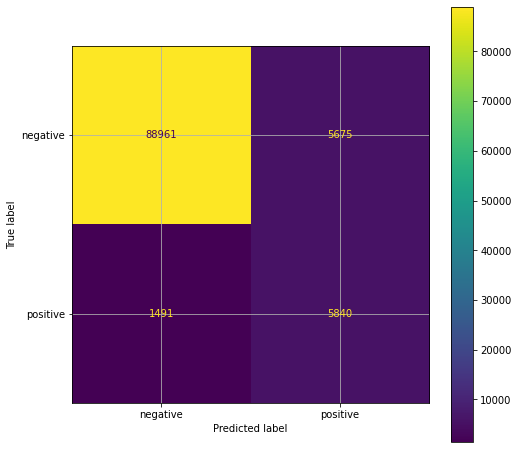

In [ ]:
#### downsampled data

xgb_post_val = xgb.XGBClassifier(objective='binary:logistic',  eval_metric='aucpr', early_stopping_rounds=10, learning_rate=0.12, max_depth=5, reg_lambda=10.0, gamma=0.25, scale_pos_weight=3)
xgb_post_val.fit(X_train, y_train,verbose=False, eval_set=[(X_val, y_val)])
xgb_post_val_pred = xgb_post_val.predict(X_test)

mh.model_evaluation(y_test, xgb_post_val_pred) 

#### downsampled data

+--------------+---------------------+
|    Metric    |        Score        |
+--------------+---------------------+
|   accuracy   |  0.8443908323281062 |
|    recall    |  0.9755831400900287 |
|  presicion   | 0.31313485113835376 |
|   f1 score   |  0.4740976434324351 |
| f_beta score |  0.6855302507476421 |
+--------------+---------------------+


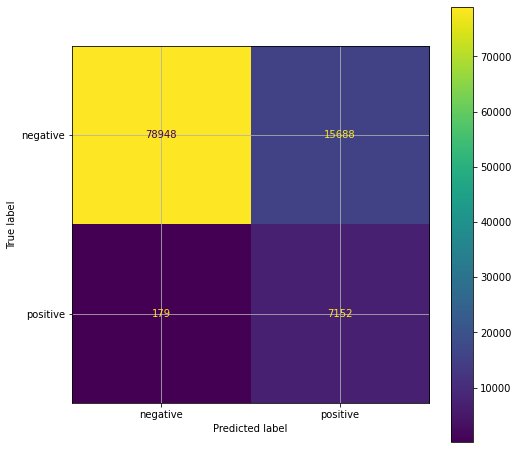

In [ ]:
#### downsampled data

xgb_post_val = xgb.XGBClassifier(objective='binary:logistic',  eval_metric='aucpr', early_stopping_rounds=10, learning_rate=0.12, max_depth=5, reg_lambda=10.0, gamma=0.25, scale_pos_weight=3)
xgb_post_val.fit(X_train_down, y_train_down,verbose=False, eval_set=[(X_val, y_val)])
xgb_post_val_pred = xgb_post_val.predict(X_test)

mh.model_evaluation(y_test, xgb_post_val_pred) 

#### upsampled data

+--------------+---------------------+
|    Metric    |        Score        |
+--------------+---------------------+
|   accuracy   |  0.8431355242382339 |
|    recall    |  0.975855954167235  |
|  presicion   |  0.3114226014278252 |
|   f1 score   | 0.47216447216447216 |
| f_beta score |  0.683991127428484  |
+--------------+---------------------+


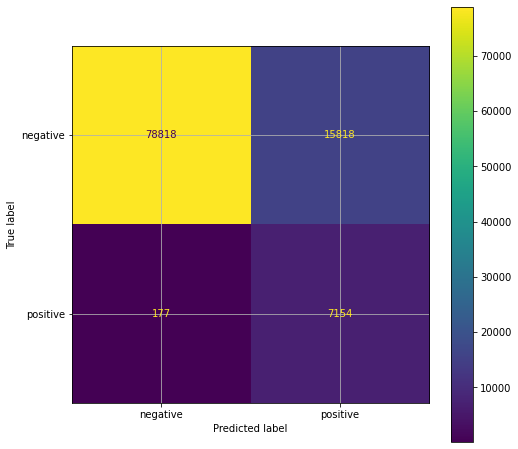

In [ ]:
#### downdampled data

xgb_post_val = xgb.XGBClassifier(objective='binary:logistic',  eval_metric='aucpr', early_stopping_rounds=10, learning_rate=0.12, max_depth=5, reg_lambda=10.0, gamma=0.25, scale_pos_weight=3)
xgb_post_val.fit(X_train_up, y_train_up,verbose=False, eval_set=[(X_val, y_val)])
xgb_post_val_pred = xgb_post_val.predict(X_test)

mh.model_evaluation(y_test, xgb_post_val_pred) 

---
### Simple FC neural network

#### original data

In [ ]:
# bulding a simple FC NN architecture for comparison

class FC_Net(nn.Module):
    def __init__(self, nuerons_num: list):
        super().__init__()
        self.fc1 = nn.Linear(nuerons_num[0], nuerons_num[1])
        self.fc2 = nn.Linear(nuerons_num[1], nuerons_num[2])
        self.fc3 = nn.Linear(nuerons_num[2], nuerons_num[3])        
    
    def forward(self, net_input):
        z = self.fc1(net_input)
        a = F.relu(z)
        z = self.fc2(a)
        a = F.relu(z)
        z = self.fc3(a)
        #a = F.relu(z)
        #z = self.fc4(a)

        return torch.sigmoid(z)

In [ ]:
# converting data to torch tensors
X_train_nn, y_train_nn, X_test_nn, y_test_nn, X_val_nn, y_val_nn = (torch.from_numpy(X_train.values), torch.from_numpy(y_train.values), 
                                                 torch.from_numpy(X_test.values), torch.from_numpy(y_test.values), 
                                                 torch.from_numpy(X_val.values), torch.from_numpy(y_val.values))


batch_size = 1024
y_train_nn = torch.reshape(y_train_nn, (y_train_nn.size()[0], 1))
train_set = torch.cat((X_train_nn, y_train_nn), dim=1)

# Shuffle the data before spliting so we wont get batches of all ones and all zeros
train_set = train_set[torch.randperm(train_set.size()[0]),:].float()
batches = torch.split(train_set, batch_size)

In [ ]:
net = FC_Net([20, 30, 30, 1])
loss_func = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.)
epoches = 20
cost_train_list = []
cost_val_list = []
iter_list = []
j = 0
i = 0
 
for epoch in tqdm(range(epoches), desc='epoch'):
    j = i + j 
    for i, batch in enumerate(tqdm(batches, desc='batch')):
        # get inputs and targets
        inputs, targets = batch[:,:-1], batch[:, -1]
        targets = torch.reshape(targets, (inputs.size()[0], 1))
        y_val_nn = torch.reshape(y_val_nn, (X_val_nn.size()[0], 1))
        # zero the parameters gradients 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)
        cost = loss_func(outputs, targets)
        cost.backward()
        optimizer.step()

        # get statistics
        if i % 40 == 0: # print every 10 mini-batches
            cost_val = loss_func(net.forward(X_val_nn.float()), y_val_nn.float())
            cost_val_list.append(cost_val.detach().numpy())
            cost_train_list.append(cost.detach().numpy())

            iter_list.append(j+i+1)
        

print('Finished Training')

epoch: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]

Finished Training


+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.9489540733766807 |
|    recall    | 0.5120720229163824 |
|  presicion   | 0.6975102192493496 |
|   f1 score   | 0.5905765751592857 |
| f_beta score | 0.5408286751570333 |
+--------------+--------------------+


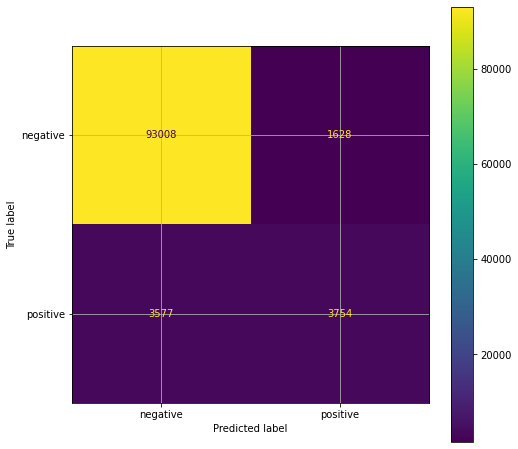

In [ ]:
y_pred = 1*(net.forward(X_test_nn.float())>0.5)
mh.model_evaluation(y_test_nn.detach().numpy(), y_pred.detach().numpy())

#### downsampled data

In [ ]:
# converting data to torch tensors
X_train_nn, y_train_nn, X_test_nn, y_test_nn, X_val_nn, y_val_nn = (torch.from_numpy(X_train_down.values), torch.from_numpy(y_train_down.values), 
                                                 torch.from_numpy(X_test.values), torch.from_numpy(y_test.values), 
                                                 torch.from_numpy(X_val.values), torch.from_numpy(y_val.values))


batch_size = 1024
y_train_nn = torch.reshape(y_train_nn, (y_train_nn.size()[0], 1))
train_set = torch.cat((X_train_nn, y_train_nn), dim=1)

# Shuffle the data before spliting so we wont get batches of all ones and all zeros
train_set = train_set[torch.randperm(train_set.size()[0]),:].float()
batches = torch.split(train_set, batch_size)

In [ ]:
net = FC_Net([20, 30, 30, 1])
loss_func = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.)
epoches = 20
cost_train_list = []
cost_val_list = []
iter_list = []
j = 0
i = 0
 
for epoch in tqdm(range(epoches), desc='epoch'):
    j = i + j 
    for i, batch in enumerate(tqdm(batches, desc='batch')):
        # get inputs and targets
        inputs, targets = batch[:,:-1], batch[:, -1]
        targets = torch.reshape(targets, (inputs.size()[0], 1))
        y_val_nn = torch.reshape(y_val_nn, (X_val_nn.size()[0], 1))
        # zero the parameters gradients 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)
        cost = loss_func(outputs, targets)
        cost.backward()
        optimizer.step()

        # get statistics
        if i % 40 == 0: # print every 10 mini-batches
            cost_val = loss_func(net.forward(X_val_nn.float()), y_val_nn.float())
            cost_val_list.append(cost_val.detach().numpy())
            cost_train_list.append(cost.detach().numpy())

            iter_list.append(j+i+1)
        

print('Finished Training')

epoch: 100%|██████████| 20/20 [00:04<00:00,  4.49it/s]

Finished Training


+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.8894152029578197 |
|    recall    | 0.9365707270495157 |
|  presicion   |  0.38841432369746  |
|   f1 score   | 0.5491042866282789 |
| f_beta score | 0.7304099912767813 |
+--------------+--------------------+


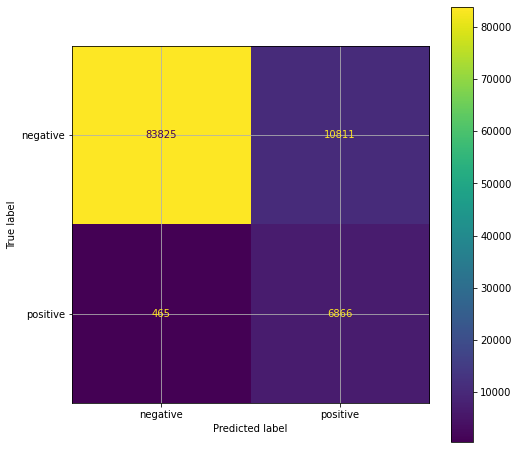

In [ ]:
y_pred = 1*(net.forward(X_test_nn.float())>0.5)
mh.model_evaluation(y_test_nn.detach().numpy(), y_pred.detach().numpy())

#### upsampled data

In [ ]:
# converting data to torch tensors
X_train_nn, y_train_nn, X_test_nn, y_test_nn, X_val_nn, y_val_nn = (torch.from_numpy(X_train_up.values), torch.from_numpy(y_train_up.values), 
                                                 torch.from_numpy(X_test.values), torch.from_numpy(y_test.values), 
                                                 torch.from_numpy(X_val.values), torch.from_numpy(y_val.values))


batch_size = 1024
y_train_nn = torch.reshape(y_train_nn, (y_train_nn.size()[0], 1))
train_set = torch.cat((X_train_nn, y_train_nn), dim=1)

# Shuffle the data before spliting so we wont get batches of all ones and all zeros
train_set = train_set[torch.randperm(train_set.size()[0]),:].float()
batches = torch.split(train_set, batch_size)

In [ ]:
net = FC_Net([20, 30, 30, 1])
loss_func = nn.BCELoss()
#optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr = 0.01, weight_decay = 0.)
epoches = 20
cost_train_list = []
cost_val_list = []
iter_list = []
j = 0
i = 0
 
for epoch in tqdm(range(epoches), desc='epoch'):
    j = i + j 
    for i, batch in enumerate(tqdm(batches, desc='batch')):
        # get inputs and targets
        inputs, targets = batch[:,:-1], batch[:, -1]
        targets = torch.reshape(targets, (inputs.size()[0], 1))
        y_val_nn = torch.reshape(y_val_nn, (X_val_nn.size()[0], 1))
        # zero the parameters gradients 
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net.forward(inputs)
        cost = loss_func(outputs, targets)
        cost.backward()
        optimizer.step()

        # get statistics
        if i % 40 == 0: # print every 10 mini-batches
            cost_val = loss_func(net.forward(X_val_nn.float()), y_val_nn.float())
            cost_val_list.append(cost_val.detach().numpy())
            cost_train_list.append(cost.detach().numpy())

            iter_list.append(j+i+1)
        

print('Finished Training')

epoch: 100%|██████████| 20/20 [00:53<00:00,  2.68s/it]

Finished Training


+--------------+---------------------+
|    Metric    |        Score        |
+--------------+---------------------+
|   accuracy   |  0.8785293281159591 |
|    recall    |  0.9500750238712318 |
|  presicion   | 0.36686858045825654 |
|   f1 score   |  0.5293357653138775 |
| f_beta score |  0.720880167256619  |
+--------------+---------------------+


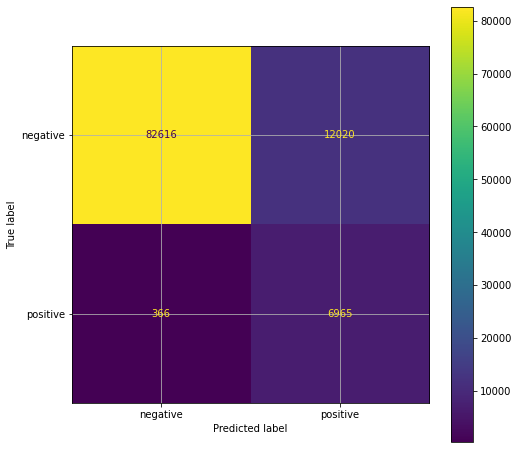

In [ ]:
y_pred = 1*(net.forward(X_test_nn.float())>0.5)
mh.model_evaluation(y_test_nn.detach().numpy(), y_pred.detach().numpy())

---
### TabNet 

In [ ]:
# define the model
TabNet = TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, n_independent=2,
                       optimizer_fn=torch.optim.Adam, # try with SGD
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":1.3},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=1, #for printing training log
                       mask_type='sparsemax' # "sparsemax" or "entmax"
                      )


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# fit the model 
TabNet.fit(
    X_train.to_numpy(),y_train.to_numpy(),
    eval_set=[(X_train.to_numpy(), y_train.to_numpy()), (X_val.to_numpy(), y_val.to_numpy())],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'], # accuracy
    max_epochs=15,
    patience=15,
    weights=0,
    batch_size=1024) #virtual_batch_size=128, used for Gohst Batch Normalization

epoch 0  | loss: 0.1331  | train_balanced_accuracy: 0.77616 | valid_balanced_accuracy: 0.77675 |  0:00:48s
epoch 1  | loss: 0.12233 | train_balanced_accuracy: 0.673   | valid_balanced_accuracy: 0.67067 |  0:01:34s
epoch 2  | loss: 0.12002 | train_balanced_accuracy: 0.67426 | valid_balanced_accuracy: 0.67107 |  0:02:19s
epoch 3  | loss: 0.11821 | train_balanced_accuracy: 0.67201 | valid_balanced_accuracy: 0.67019 |  0:03:05s
epoch 4  | loss: 0.11718 | train_balanced_accuracy: 0.66802 | valid_balanced_accuracy: 0.66633 |  0:03:51s
epoch 5  | loss: 0.11698 | train_balanced_accuracy: 0.66606 | valid_balanced_accuracy: 0.66444 |  0:04:37s
epoch 6  | loss: 0.11696 | train_balanced_accuracy: 0.6654  | valid_balanced_accuracy: 0.66403 |  0:05:24s
epoch 7  | loss: 0.11681 | train_balanced_accuracy: 0.6661  | valid_balanced_accuracy: 0.66468 |  0:06:10s
epoch 8  | loss: 0.11667 | train_balanced_accuracy: 0.66562 | valid_balanced_accuracy: 0.66443 |  0:06:56s
epoch 9  | loss: 0.11653 | train_bala

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.9445899163454843 |
|    recall    | 0.5847769744918838 |
|  presicion   | 0.621935296677789  |
|   f1 score   | 0.6027840269966254 |
| f_beta score | 0.5918491316232709 |
+--------------+--------------------+


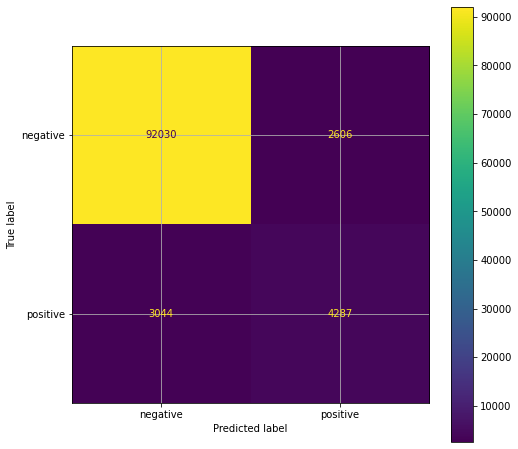

In [ ]:
# orig-sample, accuracy, w=0
y_pred = TabNet.predict(X_test.to_numpy())
ax1 = mh.model_evaluation(y_test, y_pred)

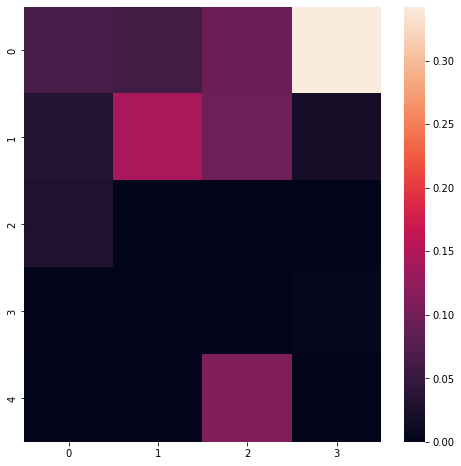

In [ ]:
# feature importance presented as a heat map. Features order is as presented is the dataset above
feature_importances = TabNet.feature_importances_
sns.heatmap(feature_importances.reshape(5,4))

In [ ]:
# define the model
TabNet = TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, n_independent=2,
                       optimizer_fn=torch.optim.Adam, # try with SGD
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":1.3},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=1, #for printing training log
                       mask_type='sparsemax' # "sparsemax" or "entmax"
                      )


/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [ ]:
# fit the model 
TabNet.fit(
    X_train.to_numpy(),y_train.to_numpy(),
    eval_set=[(X_train.to_numpy(), y_train.to_numpy()), (X_val.to_numpy(), y_val.to_numpy())],
    eval_name=['train', 'valid'],
    eval_metric=['balanced_accuracy'], # accuracy
    max_epochs=15,
    patience=15,
    weights=1,
    batch_size=1024) #virtual_batch_size=128, used for Gohst Batch Normalization

epoch 0  | loss: 0.25596 | train_balanced_accuracy: 0.90976 | valid_balanced_accuracy: 0.90987 |  0:00:48s
epoch 1  | loss: 0.23646 | train_balanced_accuracy: 0.91155 | valid_balanced_accuracy: 0.91125 |  0:01:37s
epoch 2  | loss: 0.23536 | train_balanced_accuracy: 0.91086 | valid_balanced_accuracy: 0.91199 |  0:02:23s
epoch 3  | loss: 0.23384 | train_balanced_accuracy: 0.91133 | valid_balanced_accuracy: 0.91255 |  0:03:09s
epoch 4  | loss: 0.23305 | train_balanced_accuracy: 0.91143 | valid_balanced_accuracy: 0.9123  |  0:03:54s
epoch 5  | loss: 0.23267 | train_balanced_accuracy: 0.91232 | valid_balanced_accuracy: 0.91265 |  0:04:41s
epoch 6  | loss: 0.23218 | train_balanced_accuracy: 0.9122  | valid_balanced_accuracy: 0.91235 |  0:05:29s
epoch 7  | loss: 0.23258 | train_balanced_accuracy: 0.91229 | valid_balanced_accuracy: 0.91295 |  0:06:15s
epoch 8  | loss: 0.23224 | train_balanced_accuracy: 0.91247 | valid_balanced_accuracy: 0.91299 |  0:07:02s
epoch 9  | loss: 0.23164 | train_bala

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.8784999068326027 |
|    recall    | 0.9529395716818988 |
|  presicion   | 0.3671045717288492 |
|   f1 score   | 0.530025416334737  |
| f_beta score | 0.7223807751168466 |
+--------------+--------------------+


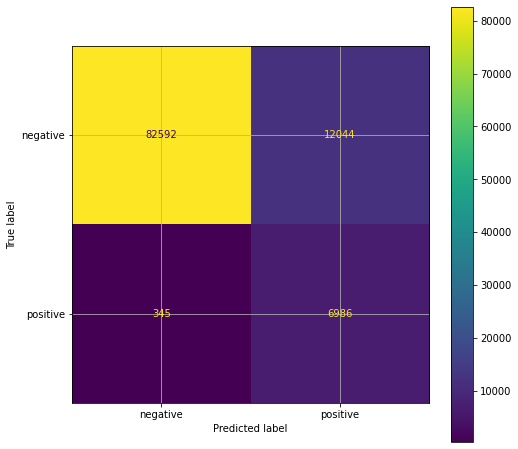

In [ ]:
# orig-sample, accuracy, w=1
y_pred = TabNet.predict(X_test.to_numpy())
mh.model_evaluation(y_test, y_pred)

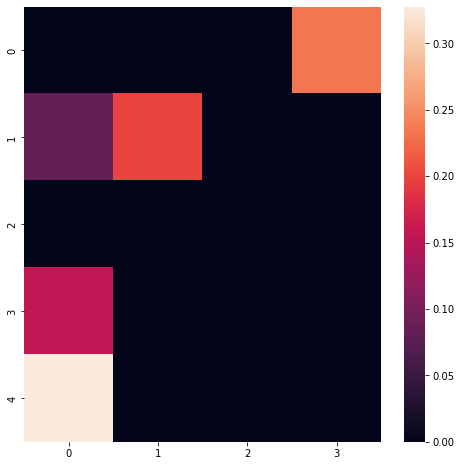

In [ ]:
# feature importance presented as a heat map. Features order is as presented is the dataset above
feature_importances = TabNet.feature_importances_
sns.heatmap(feature_importances.reshape(5,4))

In [9]:
# define the model
TabNet = TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, n_independent=2,
                       optimizer_fn=torch.optim.Adam, # try with SGD
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":1.3},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       verbose=1, #for printing training log
                       mask_type='sparsemax' # "sparsemax" or "entmax"
                      )

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [10]:
# fit the model 
TabNet.fit(
    X_train_up.to_numpy(),y_train_up.to_numpy(),
    eval_set=[(X_train_up.to_numpy(), y_train_up.to_numpy()), (X_val.to_numpy(), y_val.to_numpy())],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy'], # try training by RECALL
    max_epochs=15,
    patience=15,
    weights=0,
    batch_size=1024) #virtual_batch_size=128, used for Gohst Batch Normalization

epoch 0  | loss: 0.24305 | train_accuracy: 0.91071 | valid_accuracy: 0.86594 |  0:01:26s
epoch 1  | loss: 0.23357 | train_accuracy: 0.91203 | valid_accuracy: 0.87823 |  0:02:48s
epoch 2  | loss: 0.23244 | train_accuracy: 0.91227 | valid_accuracy: 0.88105 |  0:04:10s
epoch 3  | loss: 0.23125 | train_accuracy: 0.91206 | valid_accuracy: 0.87902 |  0:05:31s
epoch 4  | loss: 0.23103 | train_accuracy: 0.91231 | valid_accuracy: 0.87615 |  0:06:53s
epoch 5  | loss: 0.23055 | train_accuracy: 0.91205 | valid_accuracy: 0.88259 |  0:08:16s
epoch 6  | loss: 0.23391 | train_accuracy: 0.90905 | valid_accuracy: 0.8879  |  0:09:39s
epoch 7  | loss: 0.23669 | train_accuracy: 0.91217 | valid_accuracy: 0.88214 |  0:11:00s
epoch 8  | loss: 0.23234 | train_accuracy: 0.91191 | valid_accuracy: 0.87497 |  0:12:23s
epoch 9  | loss: 0.23077 | train_accuracy: 0.91254 | valid_accuracy: 0.87798 |  0:13:46s
epoch 10 | loss: 0.23528 | train_accuracy: 0.90864 | valid_accuracy: 0.86994 |  0:15:06s
epoch 11 | loss: 0.23

/usr/local/lib/python3.8/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


+--------------+--------------------+
|    Metric    |       Score        |
+--------------+--------------------+
|   accuracy   | 0.8866888307001285 |
|    recall    | 0.9307052243895785 |
|  presicion   | 0.3818344619172869 |
|   f1 score   | 0.5415079365079365 |
| f_beta score | 0.7228826308986502 |
+--------------+--------------------+


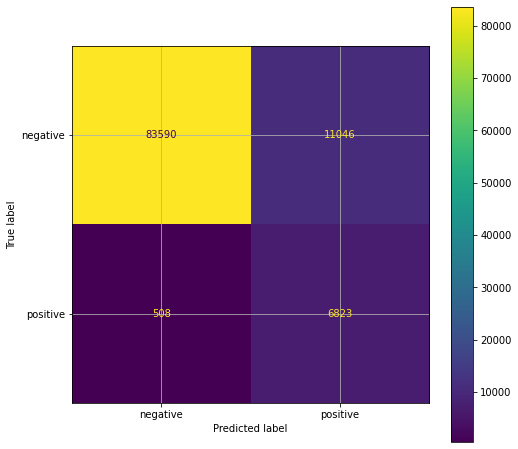

In [11]:
# upsample, accuracy, w=0
y_pred = TabNet.predict(X_test.to_numpy())
mh.model_evaluation(y_test, y_pred)

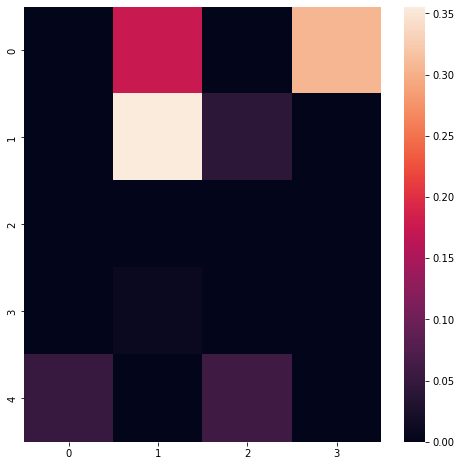

In [12]:
# feature importance presented as a heat map. Features order is as presented is the dataset above
feature_importances = TabNet.feature_importances_
sns.heatmap(feature_importances.reshape(5,4))